In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd
import helmeos
from glob import glob

In [3]:
working_directory = '/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/long_exp'
profile_directory = '/home/cnchong/Codes/cumc3d/model/Type_Ia/profile'
files = []
for f in glob(working_directory+'/*.hdf5'):
    files.append(f)
n = len(files)-1

gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
mu_0 = 1.25663706212e-6
amp2code = (mu_0*1.0e5*masscgs2code*lencgs2code)**(0.5e0)/tcgs2code
gauss2code = 1.0e-1*masscgs2code/amp2code/tcgs2code**2
energycgs2code = (1.0E0/clight**2)
me2 = 9.1093837015e-28*masscgs2code
mb2 = 1.66053906660e-24*masscgs2code
ye = 0.5e0
h_bar = (1.054571817e-27)*(lencgs2code**2*masscgs2code/tcgs2code)
amax = (me2**4)/(2.4e1*np.pi**2*h_bar**3)
bmax = (mb2*me2**3)/(3.0e0*np.pi**2*h_bar**3*ye)

In [4]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

def xe(rho):
    return (rho/bmax)**(1.0e0/3.0e0)
def dpdx(x):
    return 8.0e0*x**4/np.sqrt(x**2 + 1.0e0)
def cs(rho):
    return np.sqrt(amax*dpdx(xe(rho))/3.0e0/(rho**2*bmax)**(1.0e0/3.0e0))

def helmeos_e(dens, temp, abar, zbar):
    dens = dens/rhocgs2code
    temp = temp*1e9
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['etot']*energycgs2code
def helmeos_p(dens, temp, abar, zbar):
    dens = dens/rhocgs2code
    temp = temp*1e9
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['ptot']*(masscgs2code*energycgs2code/lencgs2code**3)
def helmeos_cs(dens, temp, abar, zbar):
    dens = dens/rhocgs2code
    temp = temp*1e9
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['cs']/clight

def easy_animation(xxf,yyf,data_list, name, ani_name):
    data_list_arr = np.array(data_list)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax,cmap='inferno')
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(vmax, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(vmin, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()
def easy_animation_levelset(xx,yy,xxf,yyf,data_list, levelset, name, ani_name):
    data_list_arr = np.array(data_list)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.contour(xx,yy,levelset[i],levels=[0],colors=['red'])
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax,cmap='inferno')
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(vmax, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(vmin, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()
def easy_animation_bfield(x1c,x3c,xxf,yyf,data_list, bfield, name, ani_name):
    data_list_arr = np.array(data_list)
    bfield_arr = np.array(bfield)
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    vmin = np.min(data_list_arr)
    vmax = np.max(data_list_arr)
    bmin = np.min(bfield_arr)
    bmax = np.max(bfield_arr)
    print(vmin)
    print(vmax)
    for i in range(len(data_list)):
        prim = data_list[i]
        quan = prim
        plt.pcolormesh(xxf,yyf,quan,vmin=vmin,vmax=vmax,cmap='binary')
        plt.streamplot(x1c,x3c,bfield[i][0,:,:].T,bfield[0][2,:,:].T, density = 1.5, color=np.log(mag_list[i][0,:,:].T**2+mag_list[0][2,:,:].T**2), cmap='inferno')
        ax.text(0.3, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    plt.colorbar(format=ticker.FuncFormatter(fmt))
    plt.annotate('max = '+np.format_float_scientific(bmin, precision=3, exp_digits=1), xy=(0.05, 0.95), xycoords='axes fraction', color = 'red')
    plt.annotate('min = '+np.format_float_scientific(bmax, precision=3, exp_digits=1), xy=(0.05, 0.9), xycoords='axes fraction', color = 'red')
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()

def animation_1D(x1c,data_list, log_flag, name, ani_name):
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    j = 0
    for i in data_list:
        j+= 1
        m = int(i.shape[1]/2)
        if log_flag == 1:
            plt.plot(x1c,np.log(i[:,m]), c = 'black')
        else:
            plt.plot(x1c,i[:,m],c='black')
        ax.text(0.25, 1.01, str(name)+ ' at time step ' +str(j), transform=ax.transAxes)
        camera.snap()
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()

def code_helm(rho_list, T_list, abar_list, zbar_list, e_list, name, ani_name):
    fig = plt.figure()
    camera = Camera(fig)
    ax = plt.axes()
    helm_elist = helmeos_e(np.array(rho_list), np.array(T_list), np.array(abar_list), np.array(zbar_list))
    for i in range(len(e_list)):
        plt.scatter(T_list[i].flatten(), e_list[i].flatten(), color='black')
        plt.scatter(T_list[i].flatten(), helm_elist[i].flatten(), facecolors='none', edgecolors='red')
        ax.text(0.25, 1.01, str(name)+ ' at time step ' +str(i), transform=ax.transAxes)
        camera.snap()
    ani = camera.animate()
    ani.save(working_directory+'/'+str(ani_name)+'.mp4')
    plt.close()

In [5]:
# Read file
filename = working_directory+"/rkiter-"+str(0)+"-nm.hdf5"
f0 = h5py.File(filename, "r")
f0.keys()
primitive = f0['primitive'][:].T
bfields = f0['bfield'][:].T


# Face value
x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
x3f = np.loadtxt(profile_directory+'/hydro_x3_fgrid.dat').T
# Center value
x1f = x1f [3:-3]*lencgs2code # Remove BC
x1c = (x1f[1:]+x1f[:-1])/2 #mid pt
x3f = x3f[3:-3]*lencgs2code # Remove BC
x3c = (x3f[1:]+x3f[:-1])/2 #mid pt

xx,yy= np.meshgrid(x1c,x3c,indexing='ij')

xxf, yyf = np.meshgrid(x1f,x3f,indexing='ij')

dx = np.diff(x1f)[0]
# dx2 = np.diff(xxf[:,0]**2)
# dy = np.diff(yyf[0,:])
# dxx2,dyy = np.meshgrid(dx2,dy,indexing='ij')
# vol = dxx2*dyy*np.pi

vol = (f0['vol'][:].T)[:,0,:]

In [6]:
bx = bfields[0,1:-1,1:-1,1:-1]/gauss2code
by = bfields[1,1:-1,1:-1,1:-1]/gauss2code
bz = bfields[2,1:-1,1:-1,1:-1]/gauss2code

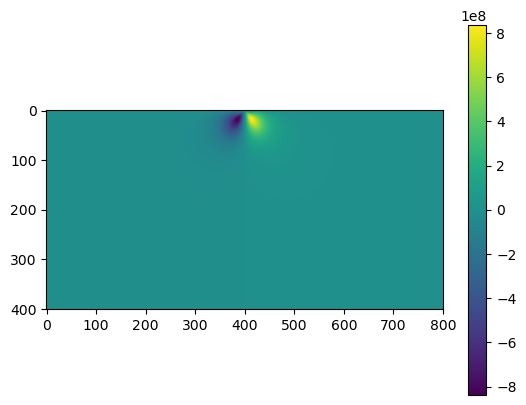

In [8]:
plt.imshow(bx[:,0,:])
plt.colorbar()

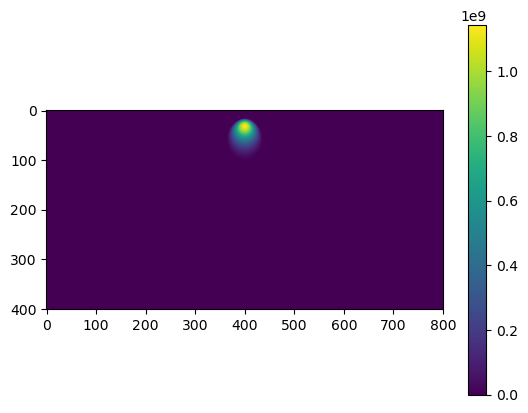

In [9]:
plt.imshow(by[:,0,:])
plt.colorbar()

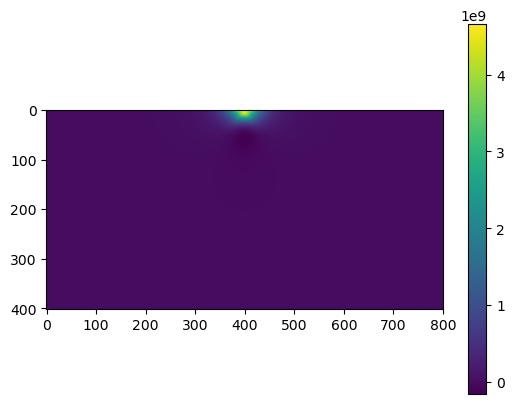

In [10]:
plt.imshow(bz[:,0,:])
plt.colorbar()

In [5]:
prim_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    primitive = f['primitive'][:]
    primitive = primitive.T
    prim_list.append(primitive)
    f.close()

epsilon_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    epsilon = f['epsilon'][:]
    epsilon = epsilon.T
    epsilon_list.append(epsilon)
    f.close()

temp_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    temp = f['temp'][:]
    temp = temp.T
    temp_list.append(temp)
    f.close()

abar_list = []
zbar_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    abar = f['abar'][:]
    abar = abar.T
    abar_list.append(abar)
    f.close()
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    zbar = f['zbar'][:]
    zbar = zbar.T
    zbar_list.append(zbar)
    f.close()

cs_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    cs = f['cs'][:]
    cs = cs.T
    cs_list.append(cs)
    f.close()
phi_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    phi = f['phi'][:]
    phi = phi.T
    phi_list.append(phi)
    f.close()
mag_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    mag = f['bfield'][2:-1,1,2:-1,:]
    mag = mag.T
    mag_list.append(mag)
    f.close()

b_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    b = f['bfield'][:]
    b = b.T
    b_list.append(b)
    f.close()

dbdt_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    dbdt = f['dbdt'][:]
    dbdt = dbdt.T
    dbdt_list.append(dbdt)
    f.close()

In [ ]:
any_list = []
for i in range(len(prim_list)):
    any_list.append(prim_list[i][5,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.log(np.array(any_list)),'log_turbq', 'log_turbq')

# scaG1_list = []
# for i in range(len(prim_list)):
#     scaG1_list.append(prim_list[i][14,1:-1,1,1:-1])
# easy_animation(xxf,yyf,np.log(np.array(scaG1_list)),'log_scaG1', 'log_scaG1')
# animation_1D(x1c,scaG1_list, 0, 'scaG1', 'eq_scaG1')

# scaG2_list = []
# for i in range(len(prim_list)):
#     scaG2_list.append(prim_list[i][15,1:-1,1,1:-1])
# easy_animation(xxf,yyf,np.log(np.array(scaG2_list)),'log_scaG2', 'log_scaG2')
# animation_1D(x1c,scaG2_list, 0, 'scaG2', 'eq_scaG2')

dens_list = []
for i in range(len(prim_list)):
    dens_list.append(prim_list[i][0,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(np.log(dens_list)), 'log_rho', 'log_rho')
# easy_animation_levelset(xx,yy,xxf,yyf,np.array(np.log(dens_list)),scaG1_list,'log_rho', 'log_rho')

animation_1D(x1c,dens_list, 1, 'Log equatorial density', 'eq_dens')

temp_anilist = []
for i in range(len(temp_list)):
    temp_anilist.append(temp_list[i][1:-1,1, 1:-1])
easy_animation(xx,yy,np.log(np.array(temp_anilist)), 'log_temp', 'log_temp')
# easy_animation_levelset(xx,yy,xxf,yyf,np.log(np.array(temp_anilist)),scaG1_list,'log_temp', 'log_temp')

animation_1D(x1c,temp_anilist, 1, 'equatorial temp', 'eq_temp')

eps_anilist = []
for i in range(len(epsilon_list)):
    eps_anilist.append(epsilon_list[i][1:-1,1, 1:-1])
easy_animation(xxf,yyf,np.log(np.array(eps_anilist)),'log_eps', 'log_eps')
# easy_animation_levelset(xx,yy,xxf,yyf,np.log(np.array(eps_anilist)), scaG1_list,'log_eps', 'log_eps')

animation_1D(x1c,eps_anilist, 1, 'log equatorial eps', 'eq_eps')

abar_anilist = []
for i in range(len(abar_list)):
    abar_anilist.append(abar_list[i][1:-1,1, 1:-1])
animation_1D(x1c,abar_anilist, 0, 'equatorial abar', 'eq_abar')
easy_animation(xx,yy,abar_anilist, 'abar', 'abar')
# easy_animation_levelset(xx,yy,xxf,yyf,abar_anilist,scaG1_list, 'abar', 'abar')
zbar_anilist = []
for i in range(len(zbar_list)):
    zbar_anilist.append(zbar_list[i][1:-1,1, 1:-1])
animation_1D(x1c,zbar_anilist, 0, 'equatorial zbar', 'eq_zbar')
easy_animation(xx,yy,zbar_anilist, 'zbar', 'zbar')
# easy_animation_levelset(xx,yy,xxf,yyf,zbar_anilist,scaG1_list, 'zbar', 'zbar')

tau_list = []
for i in range(len(prim_list)):
    tau_list.append(prim_list[i][4,1:-1,1,1:-1])
easy_animation(xx,yy,np.array(tau_list), 'tau', 'tau')
# easy_animation_levelset(xx,yy,xxf,yyf,np.array(tau_list), scaG1_list,'tau', 'tau')

vz_list = []
for i in range(len(prim_list)):
    vz_list.append(prim_list[i][3,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vz_list), 'vz', 'vz')


vx_list = []
for i in range(len(prim_list)):
    vx_list.append(prim_list[i][1,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vx_list), 'vx', 'vx')
animation_1D(x1c,vx_list, 0, 'equatorial vx', 'eq_vx')

vy_list = []
for i in range(len(prim_list)):
    vy_list.append(prim_list[i][2,1:-1,1,1:-1])
easy_animation(xxf,yyf,np.array(vy_list), 'vy', 'vy')
animation_1D(x1c,vy_list, 0, 'equatorial vy', 'eq_vy')

easy_animation_bfield(x1c,x3c,xxf,yyf,np.log(dens_list), mag_list, 'poloidal_field', 'poloidal_field')
easy_animation(xxf, yyf, np.array(mag_list)[:,1,:,:]**2/(np.array(mag_list)[:,0,:,:]**2 + np.array(mag_list)[:,2,:,:]**2), 'tp_ratio', 'tp_ratio')

easy_animation(xxf, yyf, np.array(mag_list)[:,1,:,:]**2, 'toroidal', 'toroidal')
easy_animation(xxf, yyf, (np.array(mag_list)[:,0,:,:]**2 + np.array(mag_list)[:,2,:,:]**2), 'poloidal', 'poloidal')


-23.025850929940457
-12.242175615624783
-33.04103586031136
-18.05184586376192


In [ ]:
helmeos_plist = []
helmeos_elist = []
helmeos_cslist = []

for t in range(len(dens_list)):
    helmeos_pmat = helmeos_p(dens_list[t], temp_anilist[t], abar_anilist[t], zbar_anilist[t])
    helmeos_emat = helmeos_e(dens_list[t], temp_anilist[t], abar_anilist[t], zbar_anilist[t])
    helmeos_csmat = helmeos_cs(dens_list[t], temp_anilist[t], abar_anilist[t], zbar_anilist[t])
    helmeos_plist.append(helmeos_pmat)
    helmeos_elist.append(helmeos_emat)
    helmeos_cslist.append(helmeos_csmat)

easy_animation(xx,yy,np.log(np.abs((np.array(tau_list)-np.array(helmeos_plist))/np.array(helmeos_plist))), 'pressure deviation from helmeos','dp_fh')
easy_animation(xx,yy,np.log(np.abs((np.array(eps_anilist)-np.array(helmeos_elist))/np.array(helmeos_elist))), 'energy deviation from helmeos','de_fh')

In [ ]:
t = 9
min_arg = np.argwhere(temp_anilist[t] == 1e-4)
dummy0 = []
dummy1 = []
dummy2 = []
for i in min_arg:
    dummy0.append(helmeos_elist[t][i[0],i[1]])
    dummy1.append(eps_anilist[t][i[0],i[1]])
    dummy2.append(dens_list[t][i[0],i[1]])
plt.scatter(dummy2, dummy1, label='code')
plt.scatter(dummy2, dummy0, color='red', label='helmeos')
plt.legend()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dens_list[t].flatten(),temp_anilist[t].flatten(), eps_anilist[t].flatten())
ax.scatter(dens_list[t],temp_anilist[t], helmeos_elist[t],color='red')

code_helm(dens_list, temp_anilist, abar_anilist, zbar_anilist, eps_anilist, 'eT', 'eT')



In [ ]:
plt.imshow(temp_anilist[t].T,cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(np.log(np.abs((np.array(eps_anilist[t])-np.array(helmeos_elist[t]))/np.array(helmeos_elist[t]))).T, cmap='inferno')
plt.colorbar()